In [13]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import TextVectorization
import re,string
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout,LayerNormalization

In [14]:
df=pd.read_csv('dialogs.csv',names=['question','answer'])
print(f'Dataframe size: {len(df)}')
df.head()

Dataframe size: 3725


,question,answer
0,"hi, how are you doing?",i'm fine. how about yourself?
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.
2,i'm pretty good. thanks for asking.,no problem. so how have you been?
3,no problem. so how have you been?,i've been great. what about you?
4,i've been great. what about you?,i've been good. i'm in school right now.


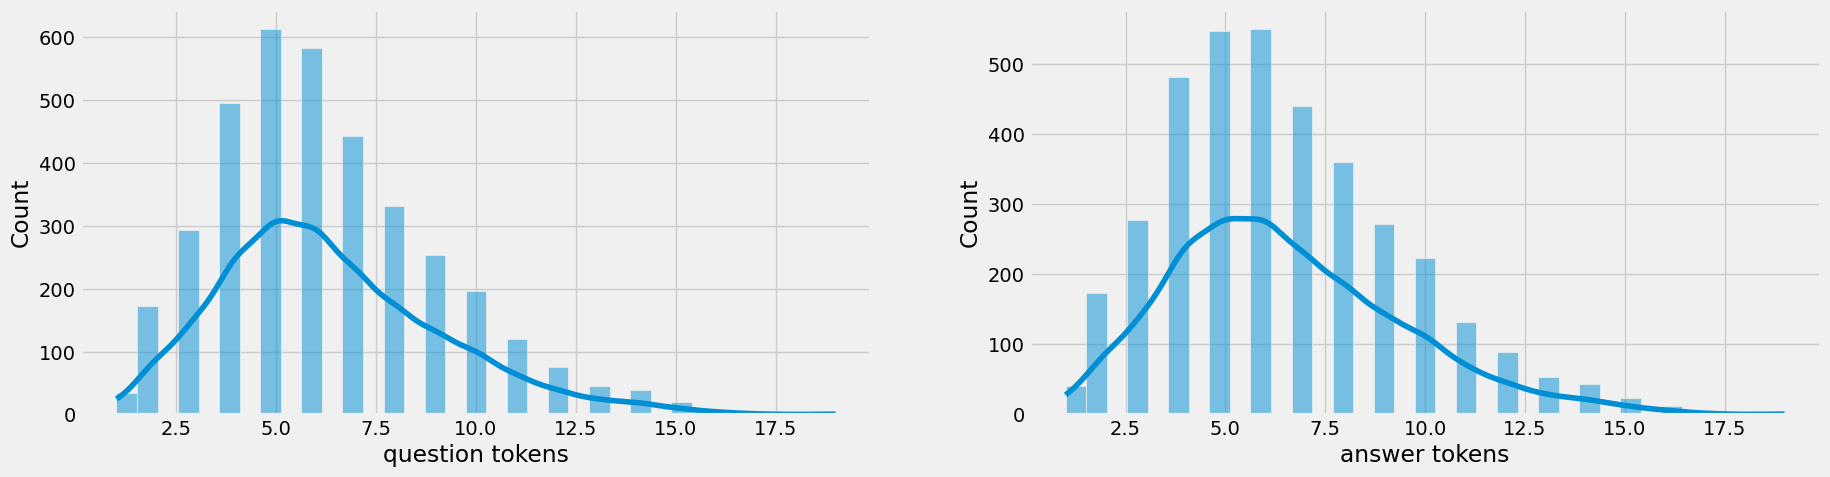

In [ ]:
#It is analyzing the token lengths of questions and answers in a dataframe (df) 
# and then plotting histograms to visualize the distribution.

df['question tokens']=df['question'].apply(lambda x:len(x.split()))
df['answer tokens']=df['answer'].apply(lambda x:len(x.split()))

#Sets the plot theme to match the style used in FiveThirtyEight (clean and minimalistic look).
plt.style.use('fivethirtyeight')


fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,5))
sns.set_palette('Set2')
sns.histplot(x=df['question tokens'],data=df,kde=True,ax=ax[0])
sns.histplot(x=df['answer tokens'],data=df,kde=True,ax=ax[1])
plt.show()

In [18]:
"cleaning"

'cleaning'

In [ ]:
def clean_text(text):
    text=re.sub('-',' ',text.lower())
    text=re.sub('[.]',' . ',text)
    text=re.sub('[1]',' 1 ',text)
    text=re.sub('[2]',' 2 ',text)
    text=re.sub('[3]',' 3 ',text)
    text=re.sub('[4]',' 4 ',text)
    text=re.sub('[5]',' 5 ',text)
    text=re.sub('[6]',' 6 ',text)
    text=re.sub('[7]',' 7 ',text)
    text=re.sub('[8]',' 8 ',text)
    text=re.sub('[9]',' 9 ',text)
    text=re.sub('[0]',' 0 ',text)
    text=re.sub('[,]',' , ',text)
    text=re.sub('[?]',' ? ',text)
    text=re.sub('[!]',' ! ',text)
    text=re.sub('[$]',' $ ',text)
    text=re.sub('[&]',' & ',text)
    text=re.sub('[/]',' / ',text)
    text=re.sub('[:]',' : ',text)
    text=re.sub('[;]',' ; ',text)
    text=re.sub('[*]',' * ',text)
    text=re.sub('[\']',' \' ',text)
    text=re.sub('[\"]',' \" ',text)
    text=re.sub('\t',' ',text)
    return text

df.drop(columns=['answer tokens','question tokens'],axis=1,inplace=True)

#Special tokens <start> / <end> give the model explicit markers for “begin generating now” and “stop here”, 
# improving convergence and preventing runaway text generation.

df['encoder_inputs']=df['question'].apply(clean_text)
df['decoder_targets']=df['answer'].apply(clean_text)+' <end>'
df['decoder_inputs']='<start> '+df['answer'].apply(clean_text)+' <end>'

df.head(10)

,question,answer,encoder_inputs,decoder_targets,decoder_inputs
0,"hi, how are you doing?",i'm fine. how about yourself?,"hi , how are you doing ?",i ' m fine . how about yourself ? <end>,<start> i ' m fine . how about yourself ? <end>
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.,i ' m fine . how about yourself ?,i ' m pretty good . thanks for asking . <end>,<start> i ' m pretty good . thanks for asking...
2,i'm pretty good. thanks for asking.,no problem. so how have you been?,i ' m pretty good . thanks for asking .,no problem . so how have you been ? <end>,<start> no problem . so how have you been ? ...
3,no problem. so how have you been?,i've been great. what about you?,no problem . so how have you been ?,i ' ve been great . what about you ? <end>,<start> i ' ve been great . what about you ? ...
4,i've been great. what about you?,i've been good. i'm in school right now.,i ' ve been great . what about you ?,i ' ve been good . i ' m in school right now ...,<start> i ' ve been good . i ' m in school ri...
5,i've been good. i'm in school right now.,what school do you go to?,i ' ve been good . i ' m in school right now .,what school do you go to ? <end>,<start> what school do you go to ? <end>
6,what school do you go to?,i go to pcc.,what school do you go to ?,i go to pcc . <end>,<start> i go to pcc . <end>
7,i go to pcc.,do you like it there?,i go to pcc .,do you like it there ? <end>,<start> do you like it there ? <end>
8,do you like it there?,it's okay. it's a really big campus.,do you like it there ?,it ' s okay . it ' s a really big campus . <...,<start> it ' s okay . it ' s a really big cam...
9,it's okay. it's a really big campus.,good luck with school.,it ' s okay . it ' s a really big campus .,good luck with school . <end>,<start> good luck with school . <end>


In [ ]:
# Plot	Purpose
# Encoder Input Tokens	Are questions mostly short or long?
# Decoder Input Tokens	How long are answer inputs including <start> and <end>?
# Decoder Target Tokens	How long are the actual answers the model will try to predict?

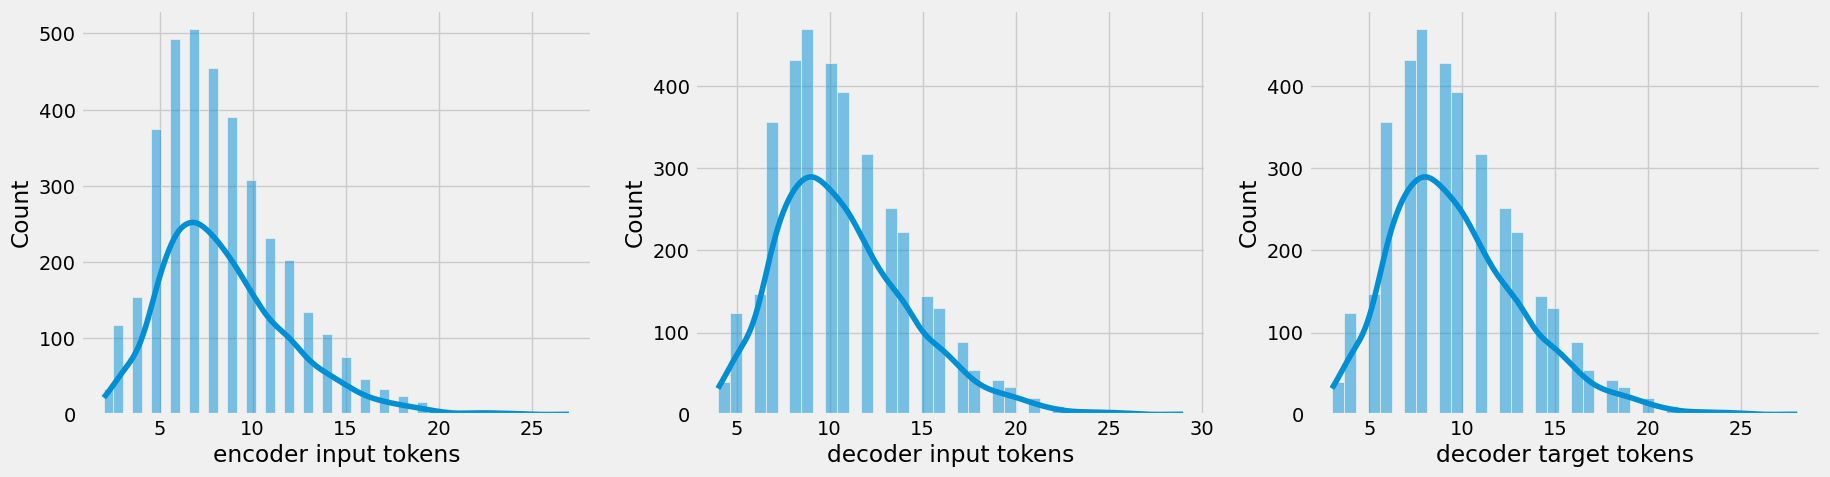

In [20]:
df['encoder input tokens']=df['encoder_inputs'].apply(lambda x:len(x.split()))
df['decoder input tokens']=df['decoder_inputs'].apply(lambda x:len(x.split()))
df['decoder target tokens']=df['decoder_targets'].apply(lambda x:len(x.split()))
plt.style.use('fivethirtyeight')
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(20,5))
sns.set_palette('Set2')
sns.histplot(x=df['encoder input tokens'],data=df,kde=True,ax=ax[0])
sns.histplot(x=df['decoder input tokens'],data=df,kde=True,ax=ax[1])
sns.histplot(x=df['decoder target tokens'],data=df,kde=True,ax=ax[2])
plt.show()

In [ ]:
#It finds the row with the longest encoder input (max() token length).

print(f"After preprocessing: {' '.join(df[df['encoder input tokens'].max()==df['encoder input tokens']]['encoder_inputs'].values.tolist())}")

# Prints the maximum token count in the encoder_inputs, decoder_inputs, and decoder_targets columns.
# This tells you how long the longest sequences are, so you can:
# Decide on a suitable max_sequence_length for padding

print(f"Max encoder input length: {df['encoder input tokens'].max()}")
print(f"Max decoder input length: {df['decoder input tokens'].max()}")
print(f"Max decoder target length: {df['decoder target tokens'].max()}")


df.drop(columns=['question','answer','encoder input tokens','decoder input tokens','decoder target tokens'],axis=1,inplace=True)

#dictionary
params={
    "vocab_size":2500,
    "max_sequence_length":30,
    "learning_rate":0.008,
    "batch_size":149,
    "lstm_cells":256,
    "embedding_dim":256,
    "buffer_size":10000
}

#break the dictionary
learning_rate=params['learning_rate']
batch_size=params['batch_size']
embedding_dim=params['embedding_dim']
lstm_cells=params['lstm_cells']
vocab_size=params['vocab_size']
buffer_size=params['buffer_size']
max_sequence_length=params['max_sequence_length']
df.head(10)

After preprocessing: for example ,  if your birth date is january  1  2  ,   1  9  8  7  ,  write  0  1  /  1  2  /  8  7  . 
Max encoder input length: 27
Max decoder input length: 29
Max decoder target length: 28


,encoder_inputs,decoder_targets,decoder_inputs
0,"hi , how are you doing ?",i ' m fine . how about yourself ? <end>,<start> i ' m fine . how about yourself ? <end>
1,i ' m fine . how about yourself ?,i ' m pretty good . thanks for asking . <end>,<start> i ' m pretty good . thanks for asking...
2,i ' m pretty good . thanks for asking .,no problem . so how have you been ? <end>,<start> no problem . so how have you been ? ...
3,no problem . so how have you been ?,i ' ve been great . what about you ? <end>,<start> i ' ve been great . what about you ? ...
4,i ' ve been great . what about you ?,i ' ve been good . i ' m in school right now ...,<start> i ' ve been good . i ' m in school ri...
5,i ' ve been good . i ' m in school right now .,what school do you go to ? <end>,<start> what school do you go to ? <end>
6,what school do you go to ?,i go to pcc . <end>,<start> i go to pcc . <end>
7,i go to pcc .,do you like it there ? <end>,<start> do you like it there ? <end>
8,do you like it there ?,it ' s okay . it ' s a really big campus . <...,<start> it ' s okay . it ' s a really big cam...
9,it ' s okay . it ' s a really big campus .,good luck with school . <end>,<start> good luck with school . <end>


In [ ]:
#Creates a tokenizer that maps words to integers

vectorize_layer=TextVectorization(
    max_tokens=vocab_size,
    standardize=None,                #You're not using default lowercase/punctuation cleaning because you already did it in clean_text()
    output_mode='int',               #output as integer
    output_sequence_length=max_sequence_length    #All sequences will be padded/truncated to this length (e.g., 30) for uniformity
)

#Learns the vocabulary from the dataset
vectorize_layer.adapt(df['encoder_inputs']+' '+df['decoder_targets']+' <start> <end>')

vocab_size=len(vectorize_layer.get_vocabulary())

print(f'Vocab size: {len(vectorize_layer.get_vocabulary())}')
print(f'{vectorize_layer.get_vocabulary()[:12]}')      #This prints the first 12 tokens in the vocabulary.


Vocab size: 2443
['', '[UNK]', '<end>', '.', '<start>', "'", 'i', '?', 'you', ',', 'the', 'to']


In [23]:
def sequences2ids(sequence):
    return vectorize_layer(sequence)

def ids2sequences(ids):
    decode=''
    if type(ids)==int:
        ids=[ids]
    for id in ids:
        decode+=vectorize_layer.get_vocabulary()[id]+' '
    return decode

x=sequences2ids(df['encoder_inputs'])
yd=sequences2ids(df['decoder_inputs'])
y=sequences2ids(df['decoder_targets'])

print(f'Question sentence: hi , how are you ?')
print(f'Question to tokens: {sequences2ids("hi , how are you ?")[:10]}')
print(f'Encoder input shape: {x.shape}')
print(f'Decoder input shape: {yd.shape}')
print(f'Decoder target shape: {y.shape}')

Question sentence: hi , how are you ?
Question to tokens: [1971    9   45   24    8    7    0    0    0    0]
Encoder input shape: (3725, 30)
Decoder input shape: (3725, 30)
Decoder target shape: (3725, 30)


In [24]:
print(f'Encoder input: {x[0][:12]} ...')
print(f'Decoder input: {yd[0][:12]} ...')    
print(f'Decoder target: {y[0][:12]} ...')

Encoder input: [1971    9   45   24    8  194    7    0    0    0    0    0] ...
Decoder input: [  4   6   5  38 646   3  45  41 563   7   2   0] ...
Decoder target: [  6   5  38 646   3  45  41 563   7   2   0   0] ...


In [ ]:
data=tf.data.Dataset.from_tensor_slices((x,yd,y))
data=data.shuffle(buffer_size)

train_data=data.take(int(.9*len(data)))
train_data=train_data.cache()
train_data=train_data.shuffle(buffer_size)
train_data=train_data.batch(batch_size)
train_data=train_data.prefetch(tf.data.AUTOTUNE)
train_data_iterator=train_data.as_numpy_iterator()

val_data=data.skip(int(.9*len(data))).take(int(.1*len(data)))  # First 90%  Remaining 10%
val_data=val_data.batch(batch_size)
val_data=val_data.prefetch(tf.data.AUTOTUNE)

_=train_data_iterator.next()
print(f'Number of train batches: {len(train_data)}')
print(f'Number of training data: {len(train_data)*batch_size}')
print(f'Number of validation batches: {len(val_data)}')
print(f'Number of validation data: {len(val_data)*batch_size}')
print(f'Encoder Input shape (with batches): {_[0].shape}')
print(f'Decoder Input shape (with batches): {_[1].shape}')
print(f'Target Output shape (with batches): {_[2].shape}')

Number of train batches: 23
Number of training data: 3427
Number of validation batches: 3
Number of validation data: 447
Encoder Input shape (with batches): (149, 30)
Decoder Input shape (with batches): (149, 30)
Target Output shape (with batches): (149, 30)


In [26]:
class Encoder(tf.keras.models.Model):
    def __init__(self,units,embedding_dim,vocab_size,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)
        self.units=units
        self.vocab_size=vocab_size
        self.embedding_dim=embedding_dim
        self.embedding=Embedding(
            vocab_size,
            embedding_dim,
            name='encoder_embedding',
            mask_zero=True,
            embeddings_initializer=tf.keras.initializers.GlorotNormal()
        )
        self.normalize=LayerNormalization()
        self.lstm=LSTM(
            units,
            dropout=.4,
            return_state=True,
            return_sequences=True,
            name='encoder_lstm',
            kernel_initializer=tf.keras.initializers.GlorotNormal()
        )
    
    def call(self,encoder_inputs):
        self.inputs=encoder_inputs
        x=self.embedding(encoder_inputs)
        x=self.normalize(x)
        x=Dropout(.4)(x)
        encoder_outputs,encoder_state_h,encoder_state_c=self.lstm(x)
        self.outputs=[encoder_state_h,encoder_state_c]
        return encoder_state_h,encoder_state_c

encoder=Encoder(lstm_cells,embedding_dim,vocab_size,name='encoder')
encoder.call(_[0])

(<tf.Tensor: shape=(149, 256), dtype=float32, numpy=
 array([[ 0.00343421,  0.14741874, -0.00664491, ...,  0.02118593,
         -0.07699282, -0.17266506],
        [-0.05057439,  0.06764443,  0.11323103, ...,  0.13441482,
          0.06150309, -0.14105499],
        [ 0.06786705,  0.01099846, -0.11104674, ...,  0.11854904,
          0.0729598 ,  0.04817402],
        ...,
        [-0.03320645,  0.18002813,  0.02309813, ..., -0.05007733,
          0.04677239,  0.10072409],
        [-0.03806698, -0.01347458, -0.00545573, ..., -0.0100695 ,
          0.04258558, -0.07640641],
        [ 0.08264815,  0.03626598,  0.02015263, ...,  0.06398473,
         -0.01982498, -0.00120983]], dtype=float32)>,
 <tf.Tensor: shape=(149, 256), dtype=float32, numpy=
 array([[ 0.01080796,  0.29030696, -0.01358611, ...,  0.03795663,
         -0.16705142, -0.36895227],
        [-0.16275272,  0.12383224,  0.26660562, ...,  0.25716934,
          0.13529791, -0.30182442],
        [ 0.16904482,  0.02753682, -0.25144017,

In [ ]:
class Decoder(tf.keras.models.Model):
    def __init__(self,units,embedding_dim,vocab_size,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)
        self.units=units
        self.embedding_dim=embedding_dim
        self.vocab_size=vocab_size

        #Converts token IDs (like 4, 57, etc.) into dense word vectors.
        self.embedding=Embedding(
            vocab_size,
            embedding_dim,
            name='decoder_embedding',
            mask_zero=True,
            embeddings_initializer=tf.keras.initializers.HeNormal()
        )

        #Normalize for stability
        self.normalize=LayerNormalization()

        self.lstm=LSTM(
            units,
            dropout=.4,
            return_state=True,
            return_sequences=True,
            name='decoder_lstm',
            kernel_initializer=tf.keras.initializers.HeNormal()
        )

        self.fc=Dense(
            vocab_size,
            activation='softmax',
            name='decoder_dense',
            kernel_initializer=tf.keras.initializers.HeNormal()
        )
    
    def call(self,decoder_inputs,encoder_states):
        x=self.embedding(decoder_inputs)
        x=self.normalize(x)
        x=Dropout(.4)(x)
        x,decoder_state_h,decoder_state_c=self.lstm(x,initial_state=encoder_states)
        x=self.normalize(x)
        x=Dropout(.4)(x)
        return self.fc(x)

decoder=Decoder(lstm_cells,embedding_dim,vocab_size,name='decoder')
decoder(_[1][:1],encoder(_[0][:1]))

<tf.Tensor: shape=(1, 30, 2443), dtype=float32, numpy=
array([[[7.5274715e-05, 3.2163493e-04, 1.5009184e-05, ...,
         2.4031692e-04, 2.5642681e-04, 1.4173480e-04],
        [1.0251282e-04, 1.9279902e-05, 9.6437907e-06, ...,
         2.7112250e-04, 3.4617947e-04, 1.5884561e-04],
        [1.5707173e-04, 8.1553662e-06, 2.7690181e-05, ...,
         5.4282926e-05, 3.2879438e-04, 9.0615104e-05],
        ...,
        [3.2823260e-05, 6.4899163e-05, 9.4457901e-05, ...,
         4.3585544e-04, 2.6067061e-04, 9.6776188e-05],
        [3.2823260e-05, 6.4899163e-05, 9.4457901e-05, ...,
         4.3585544e-04, 2.6067061e-04, 9.6776188e-05],
        [3.2823260e-05, 6.4899163e-05, 9.4457901e-05, ...,
         4.3585544e-04, 2.6067061e-04, 9.6776181e-05]]], dtype=float32)>

In [28]:

class ChatBotTrainer(tf.keras.models.Model):
    def __init__(self,encoder,decoder,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.encoder=encoder
        self.decoder=decoder

    def loss_fn(self,y_true,y_pred):
        loss=self.loss(y_true,y_pred)
        mask=tf.math.logical_not(tf.math.equal(y_true,0))
        mask=tf.cast(mask,dtype=loss.dtype)
        loss*=mask
        return tf.reduce_mean(loss)
    __
    def accuracy_fn(self,y_true,y_pred):
        pred_values = tf.cast(tf.argmax(y_pred, axis=-1), dtype='int64')
        correct = tf.cast(tf.equal(y_true, pred_values), dtype='float64')
        mask = tf.cast(tf.greater(y_true, 0), dtype='float64')
        n_correct = tf.keras.backend.sum(mask * correct)
        n_total = tf.keras.backend.sum(mask)
        return n_correct / n_total

    def call(self,inputs):
        encoder_inputs,decoder_inputs=inputs
        encoder_states=self.encoder(encoder_inputs)
        return self.decoder(decoder_inputs,encoder_states)

    def train_step(self,batch):
        encoder_inputs,decoder_inputs,y=batch
        with tf.GradientTape() as tape:
            encoder_states=self.encoder(encoder_inputs,training=True)
            y_pred=self.decoder(decoder_inputs,encoder_states,training=True)
            loss=self.loss_fn(y,y_pred)
            acc=self.accuracy_fn(y,y_pred)

        variables=self.encoder.trainable_variables+self.decoder.trainable_variables
        grads=tape.gradient(loss,variables)
        self.optimizer.apply_gradients(zip(grads,variables))
        metrics={'loss':loss,'accuracy':acc}
        return metrics
    
    def test_step(self,batch):
        encoder_inputs,decoder_inputs,y=batch
        encoder_states=self.encoder(encoder_inputs,training=True)
        y_pred=self.decoder(decoder_inputs,encoder_states,training=True)
        loss=self.loss_fn(y,y_pred)
        acc=self.accuracy_fn(y,y_pred)
        metrics={'loss':loss,'accuracy':acc}
        return metrics

In [29]:
model=ChatBotTrainer(encoder,decoder,name='chatbot_trainer')
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    weighted_metrics=['loss','accuracy']
)
model(_[:2])

<tf.Tensor: shape=(149, 30, 2443), dtype=float32, numpy=
array([[[7.52747510e-05, 3.21634929e-04, 1.50091828e-05, ...,
         2.40316687e-04, 2.56426807e-04, 1.41734796e-04],
        [1.02512779e-04, 1.92798834e-05, 9.64378978e-06, ...,
         2.71122204e-04, 3.46179644e-04, 1.58845694e-04],
        [1.57071670e-04, 8.15537169e-06, 2.76901828e-05, ...,
         5.42829075e-05, 3.28794675e-04, 9.06152418e-05],
        ...,
        [3.28232709e-05, 6.48992209e-05, 9.44579806e-05, ...,
         4.35855502e-04, 2.60670698e-04, 9.67761735e-05],
        [3.28232709e-05, 6.48992209e-05, 9.44579806e-05, ...,
         4.35855502e-04, 2.60670698e-04, 9.67761735e-05],
        [3.28232709e-05, 6.48992209e-05, 9.44579806e-05, ...,
         4.35855502e-04, 2.60670698e-04, 9.67761662e-05]],

       [[2.68917880e-04, 3.35327088e-04, 2.27376240e-05, ...,
         4.52213026e-05, 9.21349492e-05, 3.40706938e-05],
        [1.69357038e-04, 3.51998053e-04, 7.93163781e-05, ...,
         6.39493664e-05, 2

In [30]:
history=model.fit(
    train_data,
    epochs=50,
    validation_data=val_data,
    callbacks=[
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        tf.keras.callbacks.ModelCheckpoint('ckpt',verbose=1,save_best_only=True)
    ]
)

Epoch 1/50
23/23 [==============================] - ETA: 0s - loss: 1.6615 - accuracy: 0.2203
Epoch 1: val_loss improved from inf to 1.33616, saving model to ckpt
23/23 [==============================] - 59s 2s/step - loss: 1.6534 - accuracy: 0.2215 - val_loss: 1.3362 - val_accuracy: 0.2989
Epoch 2/50
23/23 [==============================] - ETA: 0s - loss: 1.2259 - accuracy: 0.3114
Epoch 2: val_loss improved from 1.33616 to 1.09722, saving model to ckpt
23/23 [==============================] - 46s 2s/step - loss: 1.2213 - accuracy: 0.3118 - val_loss: 1.0972 - val_accuracy: 0.3396
Epoch 3/50
23/23 [==============================] - ETA: 0s - loss: 1.0959 - accuracy: 0.3413
Epoch 3: val_loss improved from 1.09722 to 0.96422, saving model to ckpt
23/23 [==============================] - 46s 2s/step - loss: 1.0930 - accuracy: 0.3420 - val_loss: 0.9642 - val_accuracy: 0.3671
Epoch 4/50
23/23 [==============================] - ETA: 0s - loss: 1.0171 - accuracy: 0.3559
Epoch 4: val_loss did 

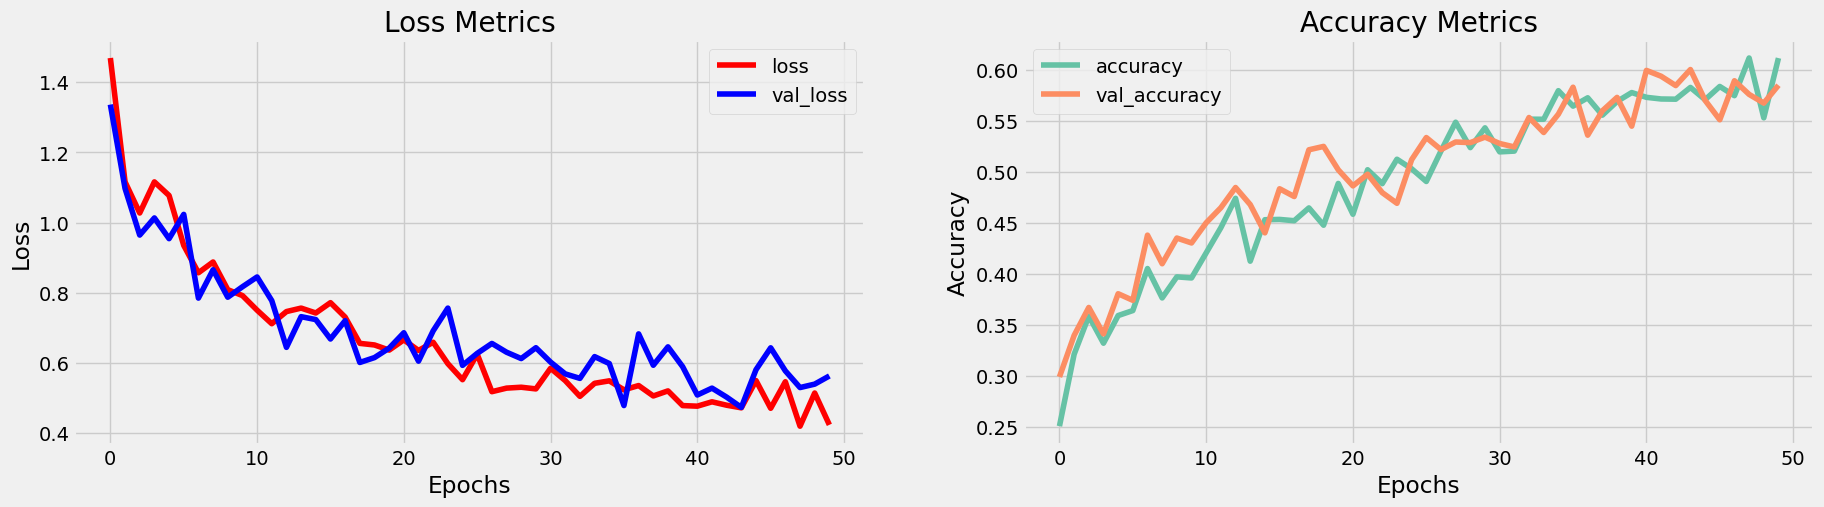

In [31]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,5))
ax[0].plot(history.history['loss'],label='loss',c='red')
ax[0].plot(history.history['val_loss'],label='val_loss',c = 'blue')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy')
ax[0].set_title('Loss Metrics')
ax[1].set_title('Accuracy Metrics')
ax[1].plot(history.history['accuracy'],label='accuracy')
ax[1].plot(history.history['val_accuracy'],label='val_accuracy')
ax[0].legend()
ax[1].legend()
plt.show()

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

history = {
    'loss': np.random.rand(20).tolist(),
    'val_loss': np.random.rand(20).tolist(),
    'accuracy': np.random.rand(20).tolist(),
    'val_accuracy': np.random.rand(20).tolist()
}

In [ ]:
np.random.seed(42)
num_samples = 200
y_true = np.random.randint(0, 2, size=num_samples)  
y_pred_prob = np.random.rand(num_samples)           
y_pred = (y_pred_prob > 0.5).astype(int)  

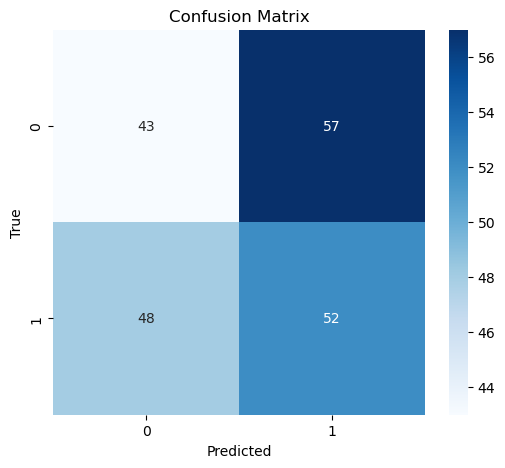

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

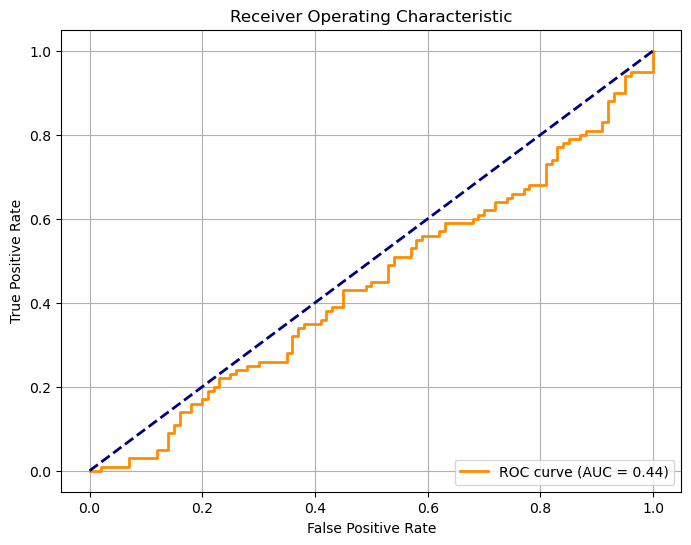

In [10]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [32]:
for idx,i in enumerate(model.layers):
    print('Encoder layers:' if idx==0 else 'Decoder layers: ')
    for j in i.layers:
        print(j)
    print('##')

Encoder layers:
##
Decoder layers: 
##


In [33]:
class ChatBot(tf.keras.models.Model):
    def __init__(self,base_encoder,base_decoder,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.encoder,self.decoder=self.build_inference_model(base_encoder,base_decoder)

    def build_inference_model(self,base_encoder,base_decoder):
        encoder_inputs=tf.keras.Input(shape=(None,))
        x=base_encoder.layers[0](encoder_inputs)
        x=base_encoder.layers[1](x)
        x,encoder_state_h,encoder_state_c=base_encoder.layers[2](x)
        encoder=tf.keras.models.Model(inputs=encoder_inputs,outputs=[encoder_state_h,encoder_state_c],name='chatbot_encoder')

        decoder_input_state_h=tf.keras.Input(shape=(lstm_cells,))
        decoder_input_state_c=tf.keras.Input(shape=(lstm_cells,))
        decoder_inputs=tf.keras.Input(shape=(None,))
        x=base_decoder.layers[0](decoder_inputs)
        x=base_encoder.layers[1](x)
        x,decoder_state_h,decoder_state_c=base_decoder.layers[2](x,initial_state=[decoder_input_state_h,decoder_input_state_c])
        decoder_outputs=base_decoder.layers[-1](x)
        decoder=tf.keras.models.Model(
            inputs=[decoder_inputs,[decoder_input_state_h,decoder_input_state_c]],
            outputs=[decoder_outputs,[decoder_state_h,decoder_state_c]],name='chatbot_decoder'
        )
        return encoder,decoder

    def summary(self):
        self.encoder.summary()
        self.decoder.summary()

    def softmax(self,z):
        return np.exp(z)/sum(np.exp(z))

    def sample(self,conditional_probability,temperature=0.5):
        conditional_probability = np.asarray(conditional_probability).astype("float64")
        conditional_probability = np.log(conditional_probability) / temperature
        reweighted_conditional_probability = self.softmax(conditional_probability)
        probas = np.random.multinomial(1, reweighted_conditional_probability, 1)
        return np.argmax(probas)

    def preprocess(self,text):
        text=clean_text(text)
        seq=np.zeros((1,max_sequence_length),dtype=np.int32)
        for i,word in enumerate(text.split()):
            seq[:,i]=sequences2ids(word).numpy()[0]
        return seq
    
    def postprocess(self,text):
        text=re.sub(' - ','-',text.lower())
        text=re.sub(' [.] ','. ',text)
        text=re.sub(' [1] ','1',text)
        text=re.sub(' [2] ','2',text)
        text=re.sub(' [3] ','3',text)
        text=re.sub(' [4] ','4',text)
        text=re.sub(' [5] ','5',text)
        text=re.sub(' [6] ','6',text)
        text=re.sub(' [7] ','7',text)
        text=re.sub(' [8] ','8',text)
        text=re.sub(' [9] ','9',text)
        text=re.sub(' [0] ','0',text)
        text=re.sub(' [,] ',', ',text)
        text=re.sub(' [?] ','? ',text)
        text=re.sub(' [!] ','! ',text)
        text=re.sub(' [$] ','$ ',text)
        text=re.sub(' [&] ','& ',text)
        text=re.sub(' [/] ','/ ',text)
        text=re.sub(' [:] ',': ',text)
        text=re.sub(' [;] ','; ',text)
        text=re.sub(' [*] ','* ',text)
        text=re.sub(' [\'] ','\'',text)
        text=re.sub(' [\"] ','\"',text)
        return text

    def call(self,text,config=None):
        input_seq=self.preprocess(text)
        states=self.encoder(input_seq,training=False)
        target_seq=np.zeros((1,1))
        target_seq[:,:]=sequences2ids(['<start>']).numpy()[0][0]
        stop_condition=False
        decoded=[]
        while not stop_condition:
            decoder_outputs,new_states=self.decoder([target_seq,states],training=False)
#             index=tf.argmax(decoder_outputs[:,-1,:],axis=-1).numpy().item()
            index=self.sample(decoder_outputs[0,0,:]).item()
            word=ids2sequences([index])
            if word=='<end> ' or len(decoded)>=max_sequence_length:
                stop_condition=True
            else:
                decoded.append(index)
                target_seq=np.zeros((1,1))
                target_seq[:,:]=index
                states=new_states
        return self.postprocess(ids2sequences(decoded))

chatbot=ChatBot(model.encoder,model.decoder,name='chatbot')
chatbot.summary()

Model: "chatbot_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 encoder_embedding (Embeddin  (None, None, 256)        625408    
 g)                                                              
                                                                 
 layer_normalization (LayerN  (None, None, 256)        512       
 ormalization)                                                   
                                                                 
 encoder_lstm (LSTM)         [(None, None, 256),       525312    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 1,151,232
Trainable params: 1,151,232

In [36]:
def print_conversation(texts):
    for text in texts:
        print(f'You: {text}')
        print(f'Bot: {chatbot(text)}')
        print('##')

In [37]:
print_conversation([
    'hi',
    'do yo know me?',
    'what is your name?',
    'you are bot?',
    'hi, how are you doing?',
    "i'm pretty good. thanks for asking.",
    "Don't ever be in a hurry",
    '''I'm gonna put some dirt in your eye ''',
    '''You're trash ''',
    '''I've read all your research on nano-technology ''',
    '''You want forgiveness? Get religion''',
    '''While you're using the bathroom, i'll order some food.''',
    '''Wow! that's terrible.''',
    '''We'll be here forever.''',
    '''I need something that's reliable.''',
    '''A speeding car ran a red light, killing the girl.''',
    '''Tomorrow we'll have rice and fish for lunch.''',
    '''I like this restaurant because they give you free bread.'''
])

You: hi
Bot: i'm throwing a party. 
##
You: do yo know me?
Bot: i'm sure. 
##
You: what is your name?
Bot: i'm sleepy. 
##
You: you are bot?
Bot: i'm not sure. 
##
You: hi, how are you doing?
Bot: i'm fine. i'm going to give a party on friday. 
##
You: i'm pretty good. thanks for asking.
Bot: i'm not being nosey. she's going to have a job. 
##
You: Don't ever be in a hurry
Bot: it's the middle of summer, it shouldn't be raining. 
##
You: I'm gonna put some dirt in your eye 
Bot: that's a good idea. 
##
You: You're trash 
Bot: no, you're welcome. 
##
You: I've read all your research on nano-technology 
Bot: that's a good idea. 
##
You: You want forgiveness? Get religion
Bot: yes, but i do. 
##
You: While you're using the bathroom, i'll order some food.
Bot: i'm going to have a job. i'm not sure. 
##
You: Wow! that's terrible.
Bot: yes, it is. it's ready to eat. 
##
You: We'll be here forever.
Bot: and we have to get a lot of money. 
##
You: I need something that's reliable.
Bot: you hav